In [ ]:
##############################################################
# Prediction of shedding scores using random forest regression 
##############################################################

In [15]:

# Load required libraries 
#########################

set.seed(4957936)

source("scr/functions/general/load_abs_install_pkg.R")

load_abs_install_pkg(c("phyloseq", "tidyverse", "foreach", "doParallel", "randomForest"))

dir.create("output/5_RF_regression_model")


[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

Warning message in dir.create("output/5_RF_regression_model"):
“'output/5_RF_regression_model' already exists”

In [23]:
# Extract and format data for RF regression
###########################################

ps.tf.css.01 <- readRDS("output/3_filtering_mormalization/ps_tf2_css.RDS")

source("scr/functions/data_for_rf.R")

rf.data.css.01 <- data_for_rf(phyloseq = ps.tf.css.01, 
                              class.column = 'WeightedScoreII', 
                              remove.taxa.prev.less.than = 1, 
                              return.df = TRUE)

rf.data.css.01$WeightedScoreII <- as.numeric(as.character(rf.data.css.01$WeightedScoreII))


In [19]:
# Find optimal number of trees nessasery for model
##################################################

RF.tree <- randomForest(WeightedScoreII ~ . , 
                           data = rf.data.css.01, 
                           ntree=15001)


In [11]:
# Save plot 
pdf("output/5_RF_regression_model/ntrees_test.pdf")

plot(RF.tree)

dev.off()


png 
  2

In [24]:
# Mtry tunning 
##############

source("scr/functions/Tree_Mtry_Plot.R")

cl <- makeCluster(24)

registerDoParallel(cl)

tree.mtry.plot.all <- Tree_Mtry_Plot(data = rf.data.css.01, 
                                     ntrees = 7501,
                                     start_val = ncol(rf.data.css.01/3), 
                                     stepF = 0.5, 
                                     class_colum = "WeightedScoreII", 
                                     ntimes = 3)

stopCluster(cl)


In [14]:
ggsave(plot = tree.mtry.plot.all, filename = "output/5_RF_regression_model/mtry_plot.pdf")


Saving 6.67 x 6.67 in image


In [24]:
# Test if Shedding values could be predicted using regression mode of RF
#######################################################################

# Create matrix with not overlaping samples (length 10)
source("scr/functions/rand_draw_mat.R")

rand.samp.reg <- rand_draw_mat(Samples_list = rownames(rf.data.css.01), Number_of_samp = 10)


In [26]:
# Build models and predict values
source("scr/functions/rf_and_test.R")

cl <- makeCluster(56)

registerDoParallel(cl)

rf.reg.res <- list()

for (i in 1:5) {

    res.for <- foreach(i=1:nrow(rand.samp.reg),.packages = "randomForest") %dopar% {
                rf_and_test(rf_data = rf.data.css.01, 
                samples_to_test = rand.samp.reg[i,], 
                n_samples_training = 230, 
                mtry = ncol(rf.data.css.01/3), 
                ntree = 7501, 
                variable_column = "WeightedScoreII", 
                regression_TorF = TRUE)}

    rf.reg.res[[i]] <- unlist(res.for) }

stopCluster(cl)


In [23]:
# save(rf.reg.res, file = "output/5_RF_regression_model/samples_reg_out.Rdata")


In [25]:
load("output/5_RF_regression_model/samples_reg_out.Rdata")

In [26]:
#Extract and optimize data for ploting 
######################################

# Extract metadata
p.reg.meta <- data.frame(ps.tf.css.01@sam_data[, c("CowN", "WeightedScoreII", "AgeMonth")])

p.reg.meta$ID <- rownames(p.reg.meta)

# Prepare data dor plotting 
reg.pd <- data.frame()

for(i in 1:length(rf.reg.res)) {
    
    reg.r <- data.frame(rf.reg.res[[i]])
    
    reg.r$ID <- rownames(reg.r)
    
    reg.pd <- rbind(reg.pd, left_join(reg.r, p.reg.meta, by="ID"))
    }


reg.pd.bar <- reg.pd[!duplicated(reg.pd$CowN), ]

reg.pd$CowN <- factor(reg.pd$CowN, levels=reg.pd.bar$CowN[order(as.numeric(as.character(reg.pd.bar$WeightedScoreII)))])

reg.pd.line <- data.frame(aggregate(reg.pd$rf.reg.res..i.., list(reg.pd$CowN), mean))

colnames(reg.pd.line) <- c("CowN", "PredV")


In [29]:
# Plot the results
##################

pred.val.plot <- ggplot() + 

    geom_bar(data = reg.pd[!duplicated(reg.pd$CowN), ], 
             aes(x = CowN, y = WeightedScoreII), 
             fill ="grey60", stat = "identity") + 

    geom_jitter(data = reg.pd, 
                aes(x = CowN, y = rf.reg.res..i.., color=AgeMonth), 
                width = 0.2) + 

    geom_smooth(data = reg.pd, 
                aes(x = as.numeric(CowN), y = rf.reg.res..i..), 
                method = "loess") + 
    theme_bw() + 

    theme(axis.text.x = element_text(angle = 90, hjust = 0.5)) + 

    ylab("Weighted Score") + 
    xlab("Cow ID")


`geom_smooth()` using formula 'y ~ x'


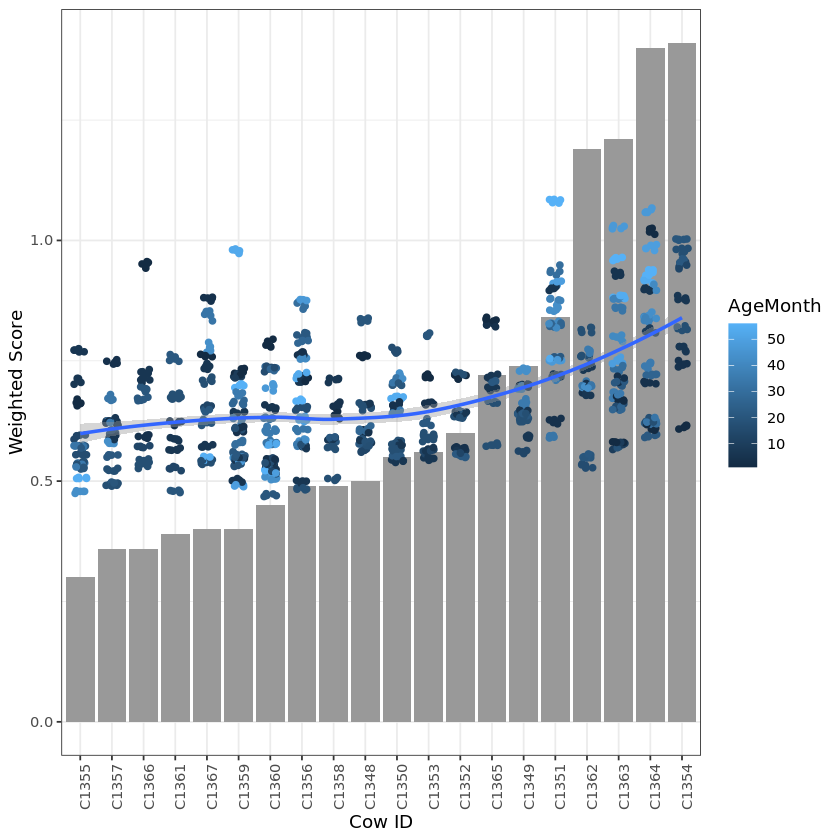

In [30]:
pred.val.plot

In [ ]:
# Save plots
ggsave(filename = "output/5_RF_regression_model/pred_reg_values.pdf", pred.val.plot, width = 7, height = 4)

ggsave(filename = "output/5_RF_regression_model/pred_reg_values.png", pred.val.plot, width = 7, height = 4, dpi=400)
